# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

The type of supervised learning problem is derived from the kind of output we are expecting. In regression we match inputs to continuous outputs, or in other words we predict the actual numeric value a specific input will have. On the other hand, in classification inputs are mapped into discrete outputs (Boolean values for example).

For this specific problem we need to detect those students who are projected to fail and need intervention. In order to reach this goal, the final dataset will be divided into two sets: Those who need intervention and does who do not. Making the problem a boolean variable and hence a __classification__ problem
    


## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [19]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [20]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns)

# TODO: Calculate passing students
n_passed =  len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
n_failed = n_students - n_passed

# TODO: Calculate graduation rate
grad_rate = (float(n_passed) / n_students) * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 31
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [21]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

from IPython.display import display
# Show the feature information by printing the first five rows
print "\nFeature values:"
# Added pretty table display
display(X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,4


### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [22]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [23]:
# TODO: Import any additional functionality you may need here

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train


# TODO: Shuffle and split the dataset into the number of training and testing points above
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=37)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

1. __Decision Tree__:
    - __Real-world Application__: Decision trees are not only used to derive mathematical knowledge, humans use it every day. The folks at [iBoske](http://www.iboske.com/) made it simple for users to create their own decision trees to help people know which camera or car to buy for example.
    - __Strengths of model__: Easy to understand and implement, since little data preparation is necessary. Fast performance on datasets that have multiple dimensions, when some of those dimensions just create noise to the algorithm and should not be considered. 
    - __Weakness__: The creation of extremely complex trees that do not properly generalize the data (overfitting). It could also create a bias tree in occasions in which a certain kind of data dominates the other. 
    - __Good Candidate__: In our dataset, we have 391 data points with 31 features each. Besides this, we do not posses any extra domain knowledge on the subject. Since we are seeking performance and avoiding the curse of dimensionality that would come with other methods, a Decision Tree is a good candidate to return results with a fast and reliable performance. The outcomes will depend on how the attributes relate to each other and the separation performed on them.
2. __Support Vector Machines (SVM)__:
    - __Real-world Application__: According to [wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#Applications) SVM are used to recognize handwritten characters and image classification.
    - __Strengths of model__: Support Vector Machines are highly effective in datasets that have high-number of dimensions (like ours) and are designed to be applied in cases that contain linearly separable data. It provides the advantage of being tuned using different kernel functions.
    - __Weakness__: Does not directly provides probabilities, which have to be obtained using the expensive process of cross-validation. So predictions tend to be slower.
    - __Good Candidate__: Due to the high number of dimensions present on the dataset, and the classification problem which is linearly separable Support Vector Machines are a great candidate for our problem. It will also provides us with great power when it comes to tuning, looking to increase performance.
3. __Ensemble Gradient Boosting__:
    - __Real-world Application__: Currently being used at Yahoo to increase their [learing to rank](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.442.1054&rep=rep1&type=pdf) web pages as query results from a web search. 
    - __Strengths of model__: With Ensemble Gradient Boosting we have the ability to detect and decrease the impact of outliers in our dataset. It contains great predictive power, since it loops through the tree several times with a different factors looking to improve the solution.
    - __Weakness__: Tend to be slower due to the sequential building of the trees. So performance wise it will take more time building the tree.
    - __Good Candidate__: This particular model according to my online sources tends to have a generally better performance than the mentioned above. It also known for being able to handle well multiple features on the data.

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [24]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    f1_training = predict_labels(clf, X_train, y_train)
    f1_test = predict_labels(clf, X_test, y_test)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(f1_training)
    print "F1 score for test set: {:.4f}.".format(f1_test)
    
    return [f1_training, f1_test]

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [25]:
# TODO: Import the three supervised learning models from sklearn
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
rand_state = 37
clf_A = tree.DecisionTreeClassifier(random_state=rand_state)
clf_B = svm.SVC(random_state=rand_state)
clf_C = GradientBoostingClassifier(random_state=rand_state)
models = [clf_A, clf_B, clf_C]


# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
results = []

for model in models:
    # TODO: Set up the training set sizes
    print '************************************************************\n'
    train = []
    test = []
    for set_size in (100,200,300):
        print '------------------------------------------------------------'
        train_values = train_predict(model, X_train[:set_size], y_train[:set_size], X_test, y_test)
        train.append(train_values[0])
        test.append(train_values[1])
    results.append(train)
    results.append(test)
        


************************************************************

------------------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0014 seconds
Made predictions in 0.0002 seconds.
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
F1 score for test set: 0.6724.
------------------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0015 seconds
Made predictions in 0.0002 seconds.
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
F1 score for test set: 0.7154.
------------------------------------------------------------
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0018 seconds
Made predictions in 0.0002 seconds.
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
F1 score for test set: 0.6891.
*****************************

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Decision Tree Classifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0014                  |  0.0004                |         1.00     |     0.6724      |
| 200               |        0.0026           |  0.0003                |         1.00     |     0.7154      |
| 300               |        0.0032           |  0.0003                |         1.00     |    0.6891       |

** Classifer 2 - Support Vector Machines (SVM)**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0024              |      0.0016            |   0.8889         |  0.7843         |
| 200               |     0.0048              |      0.0018            |   0.8679         |  0.8027         |
| 300               |     0.0105              |      0.0024            |   0.8650         |  0.7838         |

** Classifer 3 - Ensemble Gradient Boosting**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0663              |      0.0005            |      1.0000      |   0.7087        |
| 200               |     0.0857              |      0.0009            |      0.9857      |   0.7874        |
| 300               |     0.1135              |      0.0005            |      0.9670      |   0.7154        |

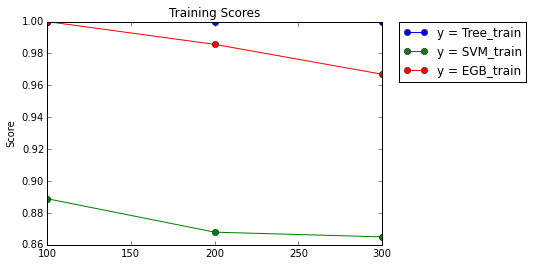

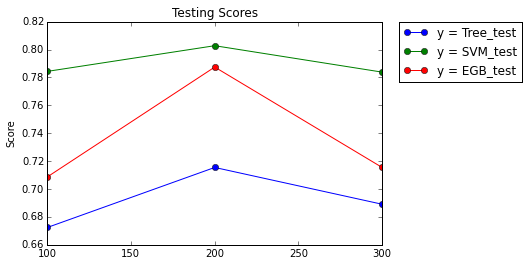

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
for a in range(3):
    plt.plot([100,200,300], results[a+a], '-o')
plt.legend(['y = Tree_train', 'y = SVM_train', 'y = EGB_train'], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.ylabel('Score')
plt.title('Training Scores')
plt.show()


for a in range(1,6,2):
    plt.plot([100,200,300], results[a], '-o')
plt.legend(['y = Tree_test', 'y = SVM_test', 'y = EGB_test'], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.ylabel('Score')
plt.title('Testing Scores')
plt.show()

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

Dear Board of supervisors, 

Given all the previous results we will be implementing the _Support Vector Machine_ model to predict which students are in need of tutoring in order to prevent them from failing. In terms of performance based on time, decision trees gives us the faster options in terms of training and testing time. However, having a perfect score on the training is not ideal in the case of the Decision tree, cause is it an indication of overfitting. This is shown in the accuracy results on the testing set by obtaining the worst outcome of the three algorithms. In comparison with Gradient Boosting, it is slower in terms of prediction but greatly faster in terms of the training set. Gradient Boosting getting close to a perfect score in the testing set is not an indication of overfitting due to the sequential building of trees the algorithm uses, which also makes a greater impact in terms of the time spent training the data. 


In conclusion, SVM provides to be the best option in terms of quality since it provides the best possible score, while also being timely efficient in the training and prediction aspects. It is also the algorithm that provides better tuning options by the ability of using a different kernel in order to improve performance. I am confident at the end of the tuning a prediction of more than 80% accuracy will be warranted. 

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **
Dear Board of Directors, 

We are currently facing a classification problem, which means we need to use all our data to determine if one element belongs to it or not based on the attributes. For example, when determining if a vehicle is a car or a motorcycle we count the number of wheels; if 2 wheels are present then is a motorcyle else it is a car. Our goal is to find out if a student will fail or not the class based on the given parameters. 


This is precisely what a Support Vector Machine does. In order to explain it let us think about a football game. During the game we have 22 players on the field, for which 11 belongs to Ohio State and 11 belong to Michigan.  Before each play starts there is an imaginary line that divides the start point of those two teams known as the line of scrimmage. What SVM does is try to find this line of scrimmage in our data, so in the case another player is added to the Michigan side, we can surely predict is in fact a Michigan player (and an illegal formation penalty for them of course). 


In SVM we might have some ignorant players rooming in the wrong side of the field, so the line of scrimmage would not precisely give us a clean separation. But it will clearly give us a line that maximizes the division between this two categories. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [34]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV


# TODO: Create the parameters list you wish to tune
parameters = {'kernel':['linear', 'rbf', 'poly','sigmoid'], 
              'C': [0.6, 1, 1.5, 3],
              'probability': [True, False],
              'tol': [1e-6,1e-5, 1e-4],
              'random_state': [37]
             }

# TODO: Initialize the classifier
clf = svm.SVC()

# TODO: Make an f1 scoring function using 'make_scorer' 
def f1_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, pos_label='yes')
    return f1
f1_scorer = make_scorer(f1_metrics)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print clf
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

SVC(C=0.6, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=37, shrinking=True,
  tol=1e-06, verbose=False)
Made predictions in 0.0055 seconds.
Tuned model has a training F1 score of 0.8300.
Made predictions in 0.0018 seconds.
Tuned model has a testing F1 score of 0.7895.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** 

| Model             | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| Un-tuned          | 0.0105                  |  0.0024                |         0.8650   |     0.7838      |
| Tuned             |        0.0056           |  0.0020                |         0.8300   |     0.7895      |

- __Scores__: In terms of scores the Tuned model gets a significant better performance in terms of testing (.0057)  but about 3.5 %  worst in terms of the training set.
- __Time__: The big performance increase in the model occured in terms of time. We were able to reduce the amount spend during training by  almost half to 0.0056 seconds and the prediction time was also reduced. 

Overall by tuning the model we were able to siglithly increase the testing scores in the model but made a huge imporvement in terms of time efficiency. 



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.